# Time series from FOCI-OpenIFS piControl

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal
import seaborn as sns
import string

In [49]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

In [50]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [51]:
from dask.distributed import Client, LocalCluster, wait

In [52]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32823 instead
  expected, actual


In [53]:
client

Client Scheduler: tcp://127.0.0.1:40357 Dashboard: http://127.0.0.1:32823/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [54]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [55]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [56]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [57]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data # .data is required in newer xarray versions
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*PSI.nc


In [58]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [59]:
ds_psi

<xarray.Dataset>
Dimensions:        (time: 25200, y: 511, x: 722, depthu: 1)
Coordinates:
  * depthu         (depthu) float32 3.047
  * time           (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
Dimensions without coordinates: y, x
Data variables:
    nav_lon        (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    nav_lat        (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    sobarstf       (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    sobarstfssh    (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    sobarstftotal  (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           /gxfs_home/geomar/smomw352/CDFTOOLS/bin//cdfpsi -u /gx...

## Read OpenIFS data

Read in monthly in case we want to look at seasonal variables

In [60]:
# OpenIFS surface
ds_sfc_1m_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1m_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/*1m*regular_sfc.nc


In [61]:
ds_sfc_1m = xr.concat( ds_sfc_1m_all, dim='time' )

## Make some time series

* Global mean T2M
* AMOC at 45N
* AMV

### Global mean T2M

In [62]:
# Select annual-mean T2M
t2m_ll = ds_sfc_1m['2t'].groupby('time.year').mean('time')

# Weighted global mean
weights = np.cos(np.deg2rad(t2m_ll.lat))
weights.name = "weights"

t2m_wgt = t2m_ll.weighted(weights)
t2m = t2m_wgt.mean(('lon','lat')).compute()

### AMOC

In [63]:
# What latitude to use
#amoc_lat = 45
amoc_lat = 26.5

# Latitudes from NEMO grid
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values

# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

# Take max stream function at specified latitude
# Then take annual means 
amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').groupby('time.year').mean('time').compute()
amoc_anom = amoc - amoc.mean('year')    

303 26.279882


### AMV

In [64]:
def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

def amv(sst):
    #lon1 = 290
    #lon2 = 360
    #lat1 = 40
    #lat2 = 70
    lon1, lon2, lat1, lat2 = 280, 360, 0, 65
    amv = wgtm( sst.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return amv

# Compute AMV index
_amv = amv(ds_sfc_1m['sstk']).compute()
    
# Annual mean
# (Note, AMV is usually defined using a 11-year running mean to avoid sub-decadal modes)
amv = _amv.groupby('time.year').mean('time')

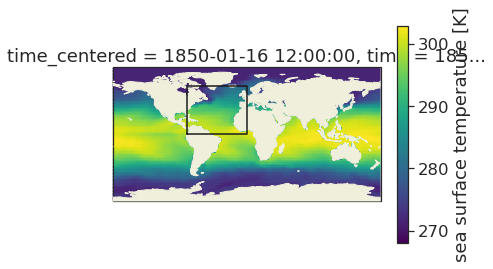

In [65]:
fig,ax=plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
ds_sfc_1m['sstk'].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100)
#ax.plot([-70,0,0,-70,-70],[40,40,70,70,40],'-k',zorder=200)
ax.plot([-80,0,0,-80,-80],[0,0,65,65,0],'-k',zorder=200)
#ax.set_extent([-100,40,0,90])
ax.set_global()

## Define phases

In [66]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3200), slice(3200,3500)]

period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

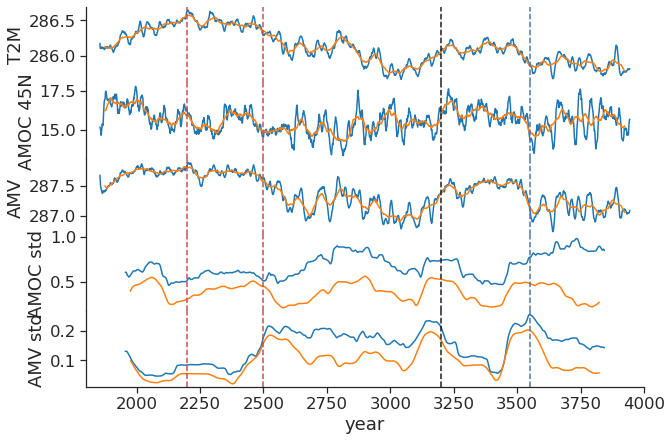

In [67]:
fig1, axs1 = plt.subplots(5,1,figsize=(10,7))
ax1 = axs1.flat

# First plot 11-year running mean
run = 11
_t2m = t2m.rolling(year=run,center=True).mean()
_amoc = amoc.rolling(year=run,center=True).mean()
_amv = amv.rolling(year=run,center=True).mean()

_t2m.plot(ax=ax1[0],c='tab:blue')
_amoc.plot(ax=ax1[1],c='tab:blue')
_amv.plot(ax=ax1[2],c='tab:blue')

_amoc.rolling(year=201,center=True).std().plot(ax=ax1[3],c='tab:blue')
_amv.rolling(year=201,center=True).std().plot(ax=ax1[4],c='tab:blue')

run = 51
_t2m = t2m.rolling(year=run,center=True).mean()
_amoc = amoc.rolling(year=run,center=True).mean()
_amv = amv.rolling(year=run,center=True).mean()

_t2m.plot(ax=ax1[0],c='tab:orange')
_amoc.plot(ax=ax1[1],c='tab:orange')
_amv.plot(ax=ax1[2],c='tab:orange')

_amoc.rolling(year=201,center=True).std().plot(ax=ax1[3],c='tab:orange')
_amv.rolling(year=201,center=True).std().plot(ax=ax1[4],c='tab:orange')

for ax in ax1:
    ax.set_xlim(1800,4000)
    ax.spines[["top","right"]].set_visible(False)
    ax.axvline(x=2200,c='r',linestyle='--')
    ax.axvline(x=2500,c='r',linestyle='--')
    ax.axvline(x=3200,c='k',linestyle='--')
    ax.axvline(x=3550,c='b',linestyle='--')
    
for ax in ax1[:-1]:
    ax.spines[["bottom", "top"]].set_visible(False)
    ax.set_title('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

labels = ['T2M','AMOC 45N','AMV','AMOC std','AMV std']
for ax,lab in zip(ax1,labels):
    ax.set_ylabel(lab)    

fig1.subplots_adjust(hspace=0)
    
fig1.savefig('figures/Timeseries.pdf',format='pdf')

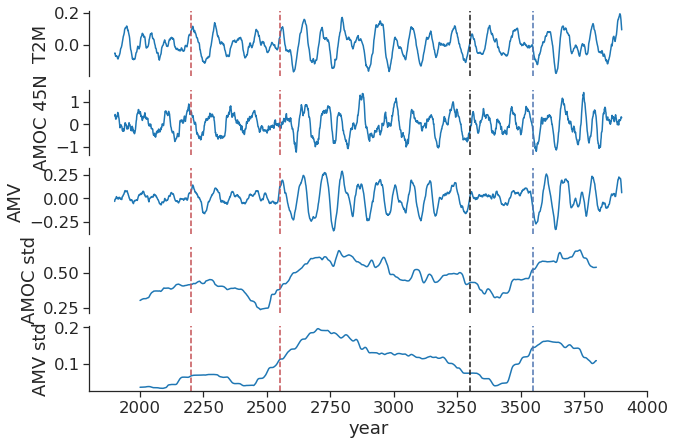

In [68]:
fig1, axs1 = plt.subplots(5,1,figsize=(10,7))
ax1 = axs1.flat

# Isolate 20-100 year variability
# by subtracting 100-year lowpass from 20-year lowpass
run1 = 21
run2 = 101
_t2m = t2m.rolling(year=run1,center=True).mean() - t2m.rolling(year=run2,center=True).mean()
_amoc = amoc.rolling(year=run1,center=True).mean() - amoc.rolling(year=run2,center=True).mean()
_amv = amv.rolling(year=run1,center=True).mean() - amv.rolling(year=run2,center=True).mean()

_t2m.plot(ax=ax1[0],c='tab:blue')
_amoc.plot(ax=ax1[1],c='tab:blue')
_amv.plot(ax=ax1[2],c='tab:blue')

_amoc.rolling(year=201,center=True).std().plot(ax=ax1[3],c='tab:blue')
_amv.rolling(year=201,center=True).std().plot(ax=ax1[4],c='tab:blue')

for ax in ax1:
    ax.set_xlim(1800,4000)
    ax.spines[["top","right"]].set_visible(False)
    ax.axvline(x=2200,c='r',linestyle='--')
    ax.axvline(x=2550,c='r',linestyle='--')
    ax.axvline(x=3300,c='k',linestyle='--')
    ax.axvline(x=3550,c='b',linestyle='--')
    
for ax in ax1[:-1]:
    ax.spines[["bottom", "top"]].set_visible(False)
    ax.set_title('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

labels = ['T2M','AMOC 45N','AMV','AMOC std','AMV std']
for ax,lab in zip(ax1,labels):
    ax.set_ylabel(lab)    

#fig1.subplots_adjust(hspace=0)
    
fig1.savefig('figures/Timeseries_20-100yr.pdf',format='pdf')

0.13041770170628397


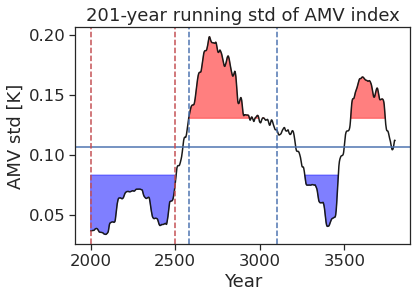

In [75]:
# Rolling std
_amoc1 = _amoc.rolling(year=201,center=True).std()
_amv1 = _amv.rolling(year=201,center=True).std()

_amv_mean = _amv1.mean('year').data
_amv_std = _amv1.std('year').data
_amv_p = _amv_mean + _amv_std * 0.5
_amv_m = _amv_mean - _amv_std * 0.5
print(_amv_p)

fig1, ax1 = plt.subplots(1,1)
ax1.plot(_amv1.year, _amv1.data, '-k')
ax1.axhline(y=_amv_mean)
ax1.fill_between(_amv1.year, _amv1.data, y2=_amv_p, where=(_amv1.data >= _amv_p), color='red', alpha=0.5)
ax1.fill_between(_amv1.year, _amv1.data, y2=_amv_m, where=(_amv1.data <= _amv_m), color='blue', alpha=0.5)

ax1.axvline(x=2000,c='r',linestyle='--')
ax1.axvline(x=2500,c='r',linestyle='--')
ax1.axvline(x=2580,c='b',linestyle='--')
ax1.axvline(x=3100,c='b',linestyle='--')
#ax1.axvline(x=3550,c='b',linestyle='--')

ax1.set_title('201-year running std of AMV index')
ax1.set_ylabel('AMV std [K]')
ax1.set_xlabel('Year')
fig1.savefig('figures/AMV_200yr_std.pdf',format='pdf')

## Define correlation 

In [70]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def correlation(x, y, dim='time'):
    cov = ((x - x.mean(dim=dim))* (y - y.mean(dim=dim))).mean(dim=dim)
    corr = cov / x.std(dim=dim) / y.std(dim=dim)
    return corr

def significance(r,n):
    t = r / np.sqrt(1 - r**2) * np.sqrt((n - 2).where(n > 2))
    p_values = t.copy()
    p_values.values = (2 
                       * sns.distributions.stats.t.sf(
                       np.abs(t.where(n>2)),
                       df=n.where(n>2)-2))
    return p_values

## Lagged correlation of AMOC, AMV

In [71]:
def lag_corr(x, y, shiftx=0, shifty=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = shiftx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

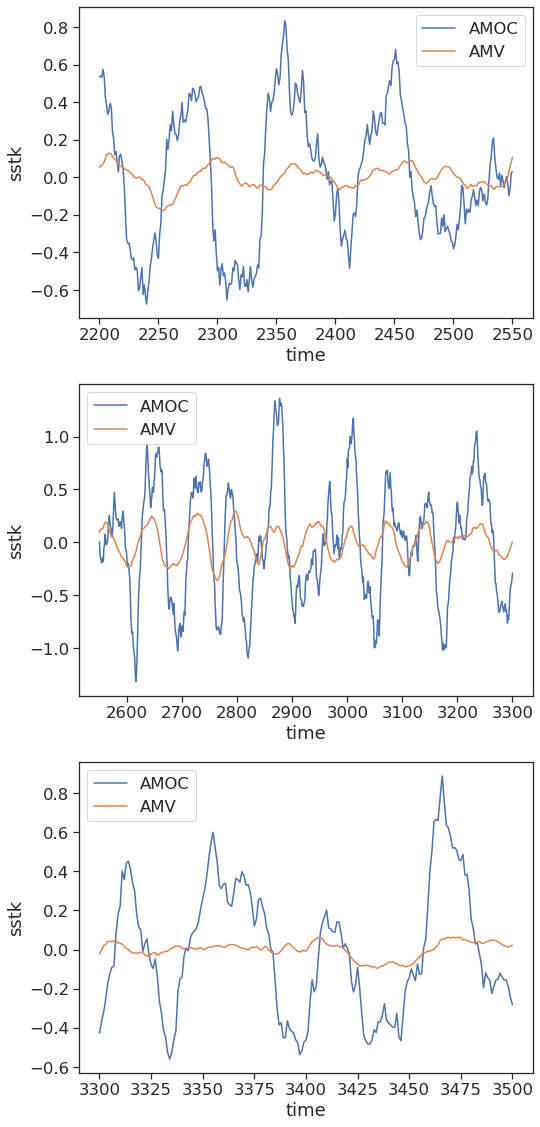

In [72]:
# Figure to control plot time series in each period
fig1, ax1 = plt.subplots(3,1,figsize=(8,16))

# Lists where we put the results
cor_list = [] # correlation (-1,1)
k_list = [] # regression (e.g. K/Sv)
p_list = [] # pvalues

# Running mean
runmean = 11

# Running mean
_amoc = amoc.rolling(year=runmean,center=True).mean()
_amv  = amv.rolling(year=runmean,center=True).mean()

# Bandpass 20-100
run1, run2 = 20, 100
_amoc = amoc.rolling(year=run1,center=True).mean() - amoc.rolling(year=run2,center=True).mean()
_amv  = amv.rolling(year=run1,center=True).mean() - amv.rolling(year=run2,center=True).mean()

# Loop over the phases
for jp, period in enumerate(period_list_yr):
    
    # List of all correlations
    da_r = []
    da_p = []
    da_k = []
    
    # Loop over lags
    # lag < 0 -> AMOC leads
    # lag > 0 -> AMOC lags
    for lagx in range(-60,61):
        
        # Select period
        # Rename to time for the function
        _x = _amoc.sel(year=period).rename({'year':'time'}) 
        _y = _amv.sel(year=period).rename({'year':'time'}) 
        
        # Detrend
        xd = detrend(_x, dim='time')
        yd = detrend(_y, dim='time')
        
        if lagx == 0:
            # Control plot
            xd.plot(ax=ax1[jp], label='AMOC')
            yd.plot(ax=ax1[jp], label='AMV')
        
        # Linear regression
        _cov, _cor, _k, _m, _p, _std = lag_corr(xd, yd, shiftx=lagx)
        
        # Add lag as dimension and append to list
        _cor['lag'] = lagx
        _p['lag'] = lagx
        _k['lag'] = lagx 
        
        da_r.append(_cor)
        da_p.append(_p)
        da_k.append(_k)
    
    # Merge along lag dimension
    cor = xr.concat(da_r,dim='lag')
    pval = xr.concat(da_p,dim='lag')
    k = xr.concat(da_k,dim='lag')
    
    # Save 
    cor_list.append(cor)
    p_list.append(pval)
    k_list.append(k)
    
for ax in ax1:
    ax.legend()
fig1.tight_layout()
fig1.savefig('figures/test_amoc_amv.pdf',format='pdf')

Phase1, peak at lag=15.000000
Phase2, peak at lag=-6.000000
Phase3, peak at lag=-2.000000


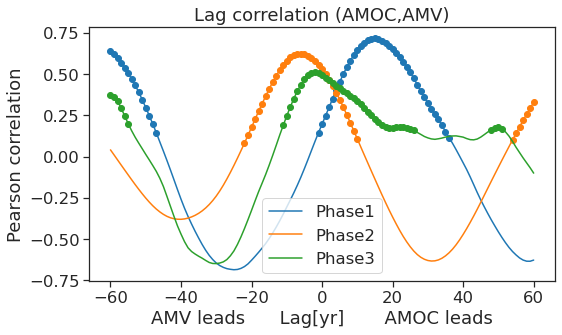

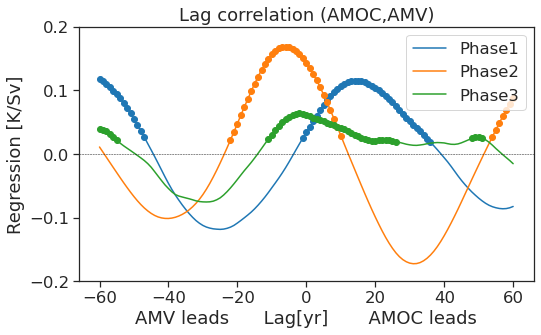

In [73]:
c_list = ['tab:blue','tab:orange','tab:green','tab:red']

fig1, ax1 = plt.subplots(1,1,figsize=(8,5))
fig2, ax2 = plt.subplots(1,1,figsize=(8,5))

for jc,(_cor, _k, _p) in enumerate( zip(cor_list, k_list, p_list) ):
    _cor.plot(ax=ax1, label=label_list[jc], c=c_list[jc])
    _cor.where(_p<0.05).plot(ax=ax1,marker='o',lw=0,c=c_list[jc])
    
    _k.plot(ax=ax2, label=label_list[jc], c=c_list[jc])
    _k.where(_p<0.05).plot(ax=ax2,marker='o',lw=0,c=c_list[jc])
    
    print('%s, peak at lag=%f' % (label_list[jc],_cor.sel(lag=slice(-20,20)).idxmax('lag')))
    
ax1.legend()
ax1.set_ylabel('Pearson correlation')
ax1.set_title('Lag correlation (AMOC,AMV)')
ax1.set_xlabel('AMV leads      Lag[yr]       AMOC leads');
fig1.tight_layout()
fig1.savefig('figures/AMOC_AMV_lag_corr_%dyr.pdf' % (runmean,),format='pdf')

ax2.legend()
ax2.set_ylim([-0.2,0.2])
ax2.axhline(y=0, linestyle='--', color='k', lw=0.5)
ax2.set_ylabel('Regression [K/Sv]')
ax2.set_title('Lag correlation (AMOC,AMV)')
ax2.set_xlabel('AMV leads      Lag[yr]       AMOC leads');
fig2.tight_layout()
fig2.savefig('figures/AMOC_AMV_lag_slope_%dyr.pdf' % (runmean,),format='pdf')

## Power spectrum analysis

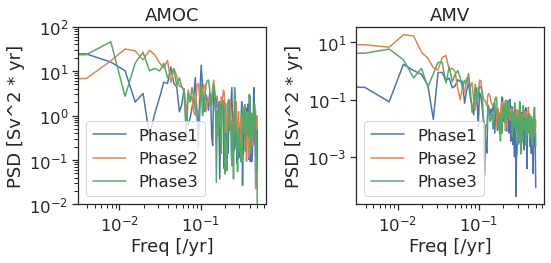

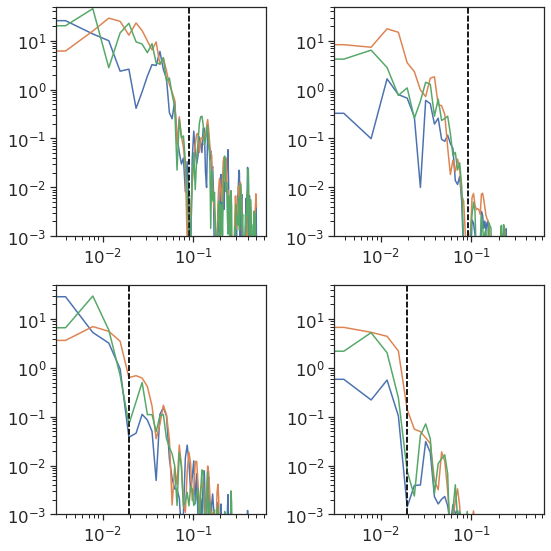

In [66]:
# Figure to plot PSD for each period
fig1, ax1 = plt.subplots(1,2,figsize=(8,4))

fig2, ax2 = plt.subplots(2,2,figsize=(8,8))

# Loop over the phases
for jp, period in enumerate(period_list_yr):
    
    _amoc = amoc.sel(year=period).rename({'year':'time'}) 
    _amv = amv.sel(year=period).rename({'year':'time'})
    
    # Detrend first
    _x = detrend(_amoc, dim='time')
    _y = detrend(_amv, dim='time')
    
    # Compute PSD using Welch method
    _freqx, _psdx = welch(_x.values, fs=1)
    _freqy, _psdy = welch(_y.values, fs=1)
    
    # Plot
    ax1[0].loglog(_freqx, _psdx, label=label_list[jp])
    ax1[1].loglog(_freqy, _psdy, label=label_list[jp])
    
    ax1[0].set_title('AMOC')
    ax1[1].set_title('AMV')
    
    ax1[0].set_ylim([1e-2,100])
    
    for jr, runmean in enumerate([11,51]):
        
        _amoc = amoc.rolling(year=runmean).mean().sel(year=period).rename({'year':'time'}) 
        _amv = amv.rolling(year=runmean).mean().sel(year=period).rename({'year':'time'})
        
        # Detrend first
        _x = detrend(_amoc, dim='time')
        _y = detrend(_amv, dim='time')
        
        # Compute PSD using Welch method
        _freqx, _psdx = welch(_x.values, fs=1)
        _freqy, _psdy = welch(_y.values, fs=1)
        
        ax2[jr,0].loglog(_freqx, _psdx, label=label_list[jp])
        ax2[jr,1].loglog(_freqy, _psdy, label=label_list[jp])
        
        ax2[jr,0].axvline(x=1.0/(runmean),c='k',linestyle='--')
        ax2[jr,1].axvline(x=1.0/(runmean),c='k',linestyle='--')
    
for ax in ax1.flat:
    ax.legend()
    ax.set_xlabel('Freq [/yr]')
    ax.set_ylabel('PSD [Sv^2 * yr]')
    
for ax in ax2.flat:
    ax.set_ylim([1e-3,50])

fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('figures/AMOC_AMV_PSD.pdf',format='pdf')